In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import copy 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

import gc
import math

from scipy.stats import mode
dy_name = 'hipstr_combine_info'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    DJ.makedir(private_out)

In [151]:
def process_combined_allele_dist(info_merge, col_name):
    """ process the alleles dist into a combined dict (combining entries from ipscore and hipsci) 
    compute mode allele and MAF based on diff from the mode like GS"""
    
    
    data = []
    inds = info_merge.index.tolist()
    for i, ind in zip(info_merge[col_name].tolist(), inds):
        
        spl = i.split(',')
        
        d = {}
        
        try:
            spl.remove('')
        except:
            pass
        
        if len(spl) <= 1:
            if len(spl[0].split(':')) == 1:
       
                continue
                
        for l in spl:
            try:
                a, n = l.split(':')
            except:
                print l, spl
                break
            n = int(n)
            d[a] = d.get(a, 0) + n
        
        
        d_nm = d.copy()
        try:
            d_nm.pop('./.')
        except:
            pass
        
        vals = d_nm.values()
        max_v = max(vals)
        num_passing = sum(vals)
        
        max_freq_alleles = [k for k in d_nm.keys() if d_nm[k] == max_v]
        num_max_freq = len(max_freq_alleles)
        max_freq_alleles = sorted(map(int, max_freq_alleles))
        
        mode_allele = max_freq_alleles[0]
        
        
        
        other_alleles = [k for k in d_nm.keys() if int(k) != mode_allele]
        nmode_sum = sum([d_nm[k] for k in other_alleles])
        
        if num_passing > 0:
            maf = nmode_sum/num_passing
        else:
            maf = 0
        
        out = [ind, d, d_nm, max_v, mode_allele, num_max_freq, max_freq_alleles, other_alleles, nmode_sum,
               num_passing, maf]
        
        
        data.append(out)
    
    col_names = ['ID', 'dict_collapsed', 'dict_no_missing', 'max_value', 'mode_allele', 'num_max_freq_alleles',
                 'max_freq_alleles', 'nmode_alleles', 'nmode_sum', 'num_passing', 'maf']

    
    df = pd.DataFrame(data, columns= col_names)
    df.index = df.ID
    df.index.name = 'index'

    return df

In [160]:
def combine_info_discoveries(info_gt, info_gt_ipscore, info_gt_ih, info_dosage , info_dosage_ipscore, info_dosage_ih, sample_info):
    
    
    def prep_info(df):
        df = df.copy()
        df = df.set_index('ID', drop=False)
        return df 
        
    def safenan_check(x):
        try:
            return math.isnan(x)

        except:
            return False     
        
        
    def get_NREF_subgroupings(info_merged, sample_info, column = 'NREF_UUID_DOSAGE_COMBINED'):
        data = []
        unrel_dict = sample_info.In_Unrelated_Set.to_dict()
        samps_unrel = set(unrel_dict.keys())
        data = []

        for x in info_merged[column].tolist():

            spl = x.split(',')

            subset_samps = [i for i in spl if i in unrel_dict]
            nnref = len(subset_samps)

            if nnref > 0:
                maf = nnref/476
            else:
                maf = 0

            data.append([nnref, maf])
        df = pd.DataFrame(data, index = info_merged.index.tolist(), columns=['NREF_DOSAGE_i2QTL_unrel', 'NREF_FRAC_DOSAGE_i2QTL_unrel'])
        return df
            
        
    def add_across_3_sets(var,info_gt, info_gt_ih, info_gt_ipscore, tdf):
        d = info_gt[var].to_dict()
        d.update(info_gt_ih[var].to_dict())
        d.update(info_gt_ipscore[var].to_dict())

        tdf[var] = tdf['ID'].apply(lambda x: d[x])
        return tdf
    
    

        df = pd.DataFrame(data, index = info_merged.index.tolist(), columns=['NREF_DOSAGE_i2QTL_unrel', 'NREF_FRAC_DOSAGE_i2QTL_unrel'])
        return df


    
    
    ids_ipscore_hipsci = info_gt_ih[info_gt_ih.NREF > 0].ID.tolist()

    ids_hipsci = info_gt[info_gt.NREF>0].ID.tolist()
    ids_ipscore = info_gt_ipscore[info_gt_ipscore.NREF > 0]['ID'].tolist()


    unique_to_ipscore_hipsci = set(ids_ipscore_hipsci).difference(ids_hipsci)
    unique_to_ipscore = set(ids_ipscore).difference(ids_hipsci + ids_ipscore_hipsci)
    unique_to_hipsci = set(ids_hipsci).difference(ids_ipscore_hipsci)

    in_both_ipscore_hipsci = set(ids_ipscore_hipsci).intersection(ids_hipsci)
    
    
    ids_in_vcf = list(set(ids_hipsci + ids_ipscore + ids_ipscore_hipsci))

    all_ids = list(set(info_gt.ID.tolist() + info_gt_ipscore.ID.tolist() + info_gt_ih.ID.tolist()))
    
    
    tdf = pd.DataFrame(index = all_ids)

    column_names_gt = ['NNONREF_GT', 'NNONREF_FRAC_GT']
    column_names_dosage = ['NNONREF_DOSAGE', 'NNONREF_FRAC_DOSAGE', 'MIN_DOSAGE', 'MAX_DOSAGE', 'ALLELES_DIST', 'NREF_UUID_DOSAGE']
    
    data_col_names_gt = ['NREF', 'NNREF_AF']
    data_col_names_dosage = ['NREF', 'NNREF_AF', 'MIN_DOSAGE', 'MAX_DOSAGE', 'ALLELES_DIST', 'NNREF_UUIDs']
    
    dfs_dosage = [info_dosage, info_dosage_ih, info_dosage_ipscore]
    dfs_gts = [info_gt, info_gt_ih, info_gt_ipscore]
    
    suffixes_dfs = ['HipSci', 'iPSCORE_HipSci_Ref', 'iPSCORE']
    
    
    for cn, cn_out in zip(data_col_names_gt, column_names_gt):
        for df, suff in zip(dfs_gts, suffixes_dfs):
            tdf["{}_{}".format(cn_out, suff)] = df[cn]
    
    
    for cn, cn_out in zip(data_col_names_dosage, column_names_dosage):
        for df, suff in zip(dfs_dosage, suffixes_dfs):
            tdf["{}_{}".format(cn_out, suff)] = df[cn]
    

    tdf['INFO'] = ''
    
    tdf['in_vcf'] = False
    tdf.loc[ids_in_vcf, 'in_vcf'] = True

    tdf['unique_to_ipscore_hi'] = False
    tdf.loc[unique_to_ipscore_hipsci, 'unique_to_ipscore_hi' ] = True

    tdf['unique_to_hipsci'] = False
    tdf.loc[unique_to_hipsci, 'unique_to_hipsci' ] = True

    tdf['unique_to_ipscore'] = False
    tdf.loc[unique_to_ipscore, 'unique_to_ipscore' ] = True

    tdf['in_both'] = False
    tdf.loc[in_both_ipscore_hipsci, 'in_both' ] = True
    
    
   
    tdf['NNONREF_GT_COMBINED'] = tdf.NNONREF_GT_HipSci + tdf.NNONREF_GT_iPSCORE_HipSci_Ref

    tdf['NNONREF_FRAC_GT_COMBINED'] = tdf.NNONREF_GT_COMBINED / (272 + 202)

    tdf['NNONREF_DOSAGE_COMBINED'] = tdf.NNONREF_DOSAGE_HipSci + tdf.NNONREF_DOSAGE_iPSCORE_HipSci_Ref

    tdf['NNONREF_FRAC_DOSAGE_COMBINED'] = tdf.NNONREF_DOSAGE_COMBINED / (272 + 202)

    tdf['num_sets'] = tdf['unique_to_ipscore_hi	in_both	unique_to_ipscore unique_to_hipsci'.split()].apply(lambda x: "".join(['1' if i == True else '0' for i in x]).count('1'), axis=1)

    tdf['SVTYPE'] = 'STR'

    
    tdf['ID'] = tdf.index
    tdf = add_across_3_sets('PERIOD', info_gt, info_gt_ih, info_gt_ipscore, tdf)  

    cols = ['NREF_UUID_DOSAGE_HipSci', 'NREF_UUID_DOSAGE_iPSCORE_HipSci_Ref', 'NREF_UUID_DOSAGE_iPSCORE']
    for c in cols:
        tdf[c] = tdf[c].fillna('')

    tdf['NREF_UUID_DOSAGE_COMBINED'] = tdf.apply(lambda x: x['NREF_UUID_DOSAGE_HipSci'] + "," +  x['NREF_UUID_DOSAGE_iPSCORE_HipSci_Ref'], axis= 1)
    
    
    unrel_maf = get_NREF_subgroupings(tdf, sample_info)
    inds = tdf[(tdf.in_vcf == True) & (tdf.unique_to_ipscore==True)].index.tolist()
    tdf.loc[inds, 'NREF_UUID_DOSAGE_COMBINED']  =tdf.loc[inds, 'NREF_UUID_DOSAGE_iPSCORE']
    tdf = tdf.join(unrel_maf)
    
    
    col_name = 'ALLELES_DIST_i2QTL_unrel'
    tdf['ALLELES_DIST_iPSCORE_HipSci_Ref_unrel'] = info_dosage_ih[col_name]
    tdf['ALLELES_DIST_iPSCORE_unrel'] = info_dosage_ipscore[col_name]
    
    
    cols = ['ALLELES_DIST_HipSci', 'ALLELES_DIST_iPSCORE_HipSci_Ref', 'ALLELES_DIST_iPSCORE',
            'ALLELES_DIST_iPSCORE_HipSci_Ref_unrel', 'ALLELES_DIST_iPSCORE_unrel']
    
    
    for c in cols:
        tdf[c] = tdf[c].fillna('')
    
    
    
    tdf['ALLELES_DIST_COMBINED'] = tdf.apply(lambda x: x['ALLELES_DIST_HipSci'] + "," +  x['ALLELES_DIST_iPSCORE_HipSci_Ref'], axis= 1)
    
    
    
      
    tdf.loc[inds, 'ALLELES_DIST_COMBINED']  =tdf.loc[inds, 'ALLELES_DIST_iPSCORE']
  
    tdf['ALLELES_DIST_i2QTL_unrel'] = tdf.apply(lambda x: x['ALLELES_DIST_HipSci'] + "," +  x['ALLELES_DIST_iPSCORE_HipSci_Ref_unrel'], axis= 1)
    
    tdf.loc[inds, 'ALLELES_DIST_i2QTL_unrel']  =tdf.loc[inds, 'ALLELES_DIST_iPSCORE_unrel']
     
    maf_calc = process_combined_allele_dist(tdf, 'ALLELES_DIST_i2QTL_unrel')
    
    cols = 'nmode_sum	num_passing	maf'.split()
    
    tdf['ALLELES_DIST_i2QTL_unrel'] = maf_calc['dict_collapsed']
    tdf['NMODE_i2QTL_unrel'] = maf_calc['nmode_sum']
    tdf['NUM_PASS_i2QTL_unrel'] = maf_calc['num_passing']
    tdf['MAF_i2QTL_unrel'] = maf_calc['maf']
    

    return tdf, maf_calc
    
    
    
    
    

In [205]:
def add_rep_rate(info, rr_dosage, rr_dosage_ih, rr_dosage_ipscore):
    
    column_names_dosage = ['RR_DOSAGE', 'NP_VAR_DOSAGE']
    
    data_col_names_dosage = ['RR','NP_VAR']
    
    dfs_dosage = [rr_dosage, rr_dosage_ih, rr_dosage_ipscore]
    
    suffixes_dfs = ['HipSci', 'iPSCORE_HipSci_Ref', 'iPSCORE']
    
    for cn, cn_out in zip(data_col_names_dosage, column_names_dosage):
        for df, suff in zip(dfs_dosage, suffixes_dfs):
            info["{}_{}".format(cn_out, suff)] = df[cn]
            
            
            
    info['RR'] = info.RR_DOSAGE_iPSCORE_HipSci_Ref    
    inds = info[(info.in_vcf == True) & (info.unique_to_ipscore==True)].index.tolist()
    info.loc[inds, 'RR'] = info.loc[inds, 'RR_DOSAGE_iPSCORE']
    
    info['NP_VAR_TWIN'] = info.NP_VAR_DOSAGE_iPSCORE_HipSci_Ref 
    info.loc[inds, 'NP_VAR_TWIN'] = info.loc[inds, 'NP_VAR_DOSAGE_iPSCORE']
    
    
    
    return info
 

In [66]:
def prep_info(df):
    df = df.copy()
    df = df.set_index('ID', drop=False)
    return df 

# info_gt = pd.read_table('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/hipsci_filt_geno/hipstr_info_gt.tsv').pipe(prep_info)

info_gt_ipscore  = pd.read_table('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_filt_sr_geno/hipstr_info_gt.tsv').pipe(prep_info)

info_gt_ih  = pd.read_table('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref_filt_sr_geno/hipstr_info_gt.tsv').pipe(prep_info)


# info_dosage = pd.read_table('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/hipsci_filt_geno/hipstr_info_dosage.tsv').pipe(prep_info)

info_dosage_ipscore  = pd.read_table('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_filt_sr_geno/hipstr_info_dosage.tsv').pipe(prep_info)

info_dosage_ih  = pd.read_table('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref_filt_sr_geno/hipstr_info_dosage.tsv').pipe(prep_info)



In [162]:
# delete some variables for space

In [24]:
sample_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/sample_info_combined/sample_info.pkl')

In [161]:
info_merge, maf_calc = combine_info_discoveries(info_gt, info_gt_ipscore, info_gt_ih, info_dosage , info_dosage_ipscore, info_dosage_ih, sample_info)

In [164]:
del info_gt
del info_gt_ipscore 
del info_gt_ih 

del info_dosage
del info_dosage_ipscore
del info_dosage_ih

In [167]:
import gzip

In [168]:
fn = '/frazer01/home/djakubosky/software/HipSTR/references/GRCh37.hipstr_reference.bed.gz'
F = gzip.open(fn)

chroms = CM.normal_Chrs

dict_ref_info = {}
for line in F:
    line = line.rstrip()
    lin_spl = line.split()
    
    chrom = lin_spl[0]
    if chrom in chroms:
        ID = lin_spl[5]
        dict_ref_info[ID] = lin_spl    

reference_info = pd.DataFrame(dict_ref_info).T
cols = "CHROM	START	END	MOTIF_LEN	NUM_COPIES	NAME MOTIF".split()
reference_info = reference_info.reset_index()
reference_info = reference_info.set_index('index')
reference_info.columns = cols

In [247]:
def site_type(x):
    site_type = []
    for i in x:
        
        if i < 0 :
            site_type.append('DEL')
        if i > 0:
            site_type.append('DUP')

    site_type =  list(set(site_type))
    if len(site_type) > 1:
        return 'MIXED'
    if len(site_type) == 1:
        return site_type[0]
    
    else:
        return 'REF'
    

In [250]:
def add_to_maf_calc(maf_calc):
    maf_calc = maf_calc.copy()
    maf_calc['alleles'] = maf_calc['dict_no_missing'].apply(lambda x: [int(i) for i in x.keys()])
    maf_calc['num_alleles_tot'] =  maf_calc['alleles'].apply(lambda x: len(x))
    maf_calc['site_type'] = maf_calc.alleles.apply(lambda x: site_type(x))
    return maf_calc

In [251]:
maf_calc_all = process_combined_allele_dist(info_merge, 'ALLELES_DIST_COMBINED')
maf_calc_all = maf_calc_all.pipe(add_to_maf_calc)

In [253]:
maf_calc = maf_calc.pipe(add_to_maf_calc)

In [169]:
info_merge = info_merge.join(reference_info)

In [ ]:
cols = ['mode_allele', 'maf', 'alleles', 'num_alleles_tot' , 'site_type']

In [259]:
info_merge['ALLELES_COMBINED'] = maf_calc_all.alleles
info_merge['MAF_COMBINED']= maf_calc_all.maf
info_merge['NUM_ALLELES_COMBINED'] = maf_calc_all.num_alleles_tot
info_merge['SITE_TYPE_COMBINED'] = maf_calc_all.site_type
info_merge['SITE_TYPE_i2QTL_unrel'] = maf_calc.site_type
info_merge['NUM_ALLELES_i2QTL_unrel'] = maf_calc.num_alleles_tot

In [174]:
def prep_info(df):
    df = df.copy()
    df = df.set_index('ID', drop=False)
    return df 


rr_dosage = pd.read_table('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/hipsci_filt_geno/hipstr_replication_length_info.tsv').pipe(prep_info)

rr_dosage_ipscore  = pd.read_table('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_filt_sr_geno/hipstr_replication_length_info.tsv').pipe(prep_info)

rr_dosage_ih  = pd.read_table('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_qc_analysis/ipscore_hipsci_ref_filt_sr_geno/hipstr_replication_length_info.tsv').pipe(prep_info)
    

In [201]:
def add_max_dosage_across_vcf(df):
    df = df.copy()
    cols = 'MAX_DOSAGE_HipSci	MAX_DOSAGE_iPSCORE_HipSci_Ref	MAX_DOSAGE_iPSCORE MIN_DOSAGE_HipSci	MIN_DOSAGE_iPSCORE_HipSci_Ref	MIN_DOSAGE_iPSCORE'.split()
    
    
    df['max_dosage_change'] = df[cols].applymap(abs).max(axis = 1)
    inds = df[(df.in_vcf == True) & (df.unique_to_ipscore == True)].index.tolist()
    t = df.loc[inds, ['MIN_DOSAGE_iPSCORE', 'MAX_DOSAGE_iPSCORE']].applymap(abs).max(axis=1)
    df.loc[inds, 'max_dosage_change'] = t
    
    return df

In [206]:
info_merge = add_rep_rate(info_merge, rr_dosage, rr_dosage_ih, rr_dosage_ipscore)

In [202]:
info_merge = info_merge.pipe(add_max_dosage_across_vcf)

In [261]:
CM.save_dataframe('hipstr_info_merge', info_merge, private_out)

hipstr_info_merge = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_combine_info/hipstr_info_merge.pkl')
hipstr_info_merge = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_combine_info/hipstr_info_merge.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_combine_info/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_combine_info/load_pickled_nb_variables.py


# Truncate info data - easier to work with it for plotting

In [262]:
cols_trunc = ['CHROM', 'START', 'END', 'MOTIF_LEN', 'NUM_COPIES', 'NAME', 'MOTIF', 'ALLELES_DIST_i2QTL_unrel', 'ALLELES_DIST_iPSCORE', 'ALLELES_DIST_HipSci', 'ALLELES_DIST_iPSCORE_HipSci_Ref', 'NNONREF_DOSAGE_COMBINED', 'NNONREF_GT_COMBINED', 'NMODE_i2QTL_unrel', 'NUM_PASS_i2QTL_unrel', 'MAF_i2QTL_unrel', 'max_dosage_change', 'in_vcf', 'unique_to_ipscore', 'unique_to_hipsci', 'unique_to_ipscore_hi', 'in_both', 'RR', 'NP_VAR_TWIN', 'SVTYPE', 'SITE_TYPE_COMBINED', 'SITE_TYPE_i2QTL_unrel', 'NUM_ALLELES_COMBINED', 'NUM_ALLELES_i2QTL_unrel', 'MAF_COMBINED']

# did I miss any more columns that I might want? 

In [266]:
CM.save_dataframe('hipstr_info_trunc', info_merge[cols_trunc], private_out)

hipstr_info_trunc = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_combine_info/hipstr_info_trunc.pkl')
hipstr_info_trunc = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_combine_info/hipstr_info_trunc.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_combine_info/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_combine_info/load_pickled_nb_variables.py


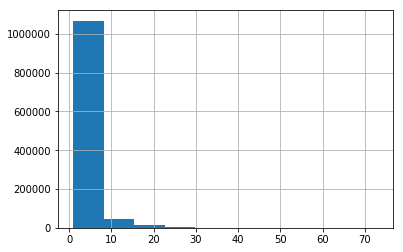

In [268]:
info_merge[cols_trunc].NUM_ALLELES_COMBINED.hist()

# Extract Dosage Per Sample VCF

In [197]:
fn_vcf = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_final_vcf/hipstr_i2QTL_merged.filt.annot.477.vcf'

In [189]:
outdir = private_out + '/dosage_per_sample_merged_vcf'
DJ.makedir(outdir)

In [1]:
DJ.convert_ipynb_to_script('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/notebooks/HipSTR_processing/hipstr_extract_dosage_cumulative.ipynb')

In [192]:
dosage_script = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/notebooks/HipSTR_processing/hipstr_extract_dosage_cumulative.py'

In [198]:
command = 'python {} -vcf {} -o {}'.format(dosage_script, fn_vcf, outdir)

In [199]:
command

'python /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/notebooks/HipSTR_processing/hipstr_extract_dosage_cumulative.py -vcf /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_final_vcf/hipstr_i2QTL_merged.filt.annot.477.vcf -o /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/hipstr_combine_info/dosage_per_sample_merged_vcf'